In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
import pickle
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import tensorflow as tf    
tf.compat.v1.disable_v2_behavior() 
import random




2024-01-13 12:06:56.945826: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 12:06:57.034896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 12:06:57.034935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-13 12:06:57.036354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-13 12:06:57.048190: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 12:06:57.048723: I tensorflow/core/platform/cpu_feature_guard.cc:1

Instructions for updating:
non-resource variables are not supported in the long term


#### definition de fonctions globales

In [2]:
def plot(x_list, y_list):
    x_axis_list = x_list
    y_axis_list = y_list

    fig = go.Figure(data=go.Scatter(x=x_axis_list, y=y_axis_list))
    fig.update_layout(
        xaxis=dict(title='Time'),
        yaxis=dict(title='Parameter Value'),
    )
    fig.show()

### Load Data

In [3]:
# Load the df_param_time_series DataFrame
with open(f"../cleaned_data/all/df_param_all.pkl", 'rb') as file:
    df_param_all = pickle.load(file)

with open("../cleaned_data/all/all_index_list.pkl", 'rb') as file:
    all_index_list = pickle.load(file)

with open("../cleaned_data/all/df_i2M2_all.pkl", 'rb') as file:
    df_i2M2 = pickle.load(file)
    

#### Préparation des outils de création de dataset

In [4]:
# On enlève les index avec "Fraction inconnue de l'eau"
for index in all_index_list:
    if "Fraction inconnue de l'eau" in index:
        all_index_list.remove(index)

In [5]:
# Definition d'un dictionnaire d'index du df_param_all par clé de station présente dans i2M2
dict_station_to_list_index_param = {}

for index in all_index_list:
    # Retrieve the station name for the current index
    station = index[1]
    
    # If the station is already in the dictionary, append the index to its list
    if station in dict_station_to_list_index_param:
        dict_station_to_list_index_param[station].append(index)
    else:
        # Otherwise, initialize a new list with the current index
        dict_station_to_list_index_param[station] = [index]

In [6]:
# Definition d'un dictionnaire d'index du df_param_all par clé de paramètres 
dict_param_to_list_index_param = {}

for index in all_index_list:
    # Retrieve the parameter name for the current index
    param = index[3]
    
    # If the parameter is already in the dictionary, append the index to its list
    if param in dict_param_to_list_index_param:
        dict_param_to_list_index_param[param].append(index)
    else:
        # Otherwise, initialize a new list with the current index
        dict_param_to_list_index_param[param] = [index]

for param, index_list in dict_param_to_list_index_param.items():
    print(f"Parameter: {param}, Number of Values: {len(index_list)}")





Parameter: Ammonium, Number of Values: 9564
Parameter: Phosphore total, Number of Values: 8009
Parameter: Nitrates, Number of Values: 9068


In [7]:
dict_HER_to_param_time_series = {}

for index in all_index_list:
    # Retrieve the HER name for the current index
    HER = index[0]

    # If the HER is already in the dictionary, append the index to its list
    if HER in dict_HER_to_param_time_series:
        dict_HER_to_param_time_series[HER].append(index)
    else:
        # Otherwise, initialize a new list with the current index
        dict_HER_to_param_time_series[HER] = [index]




HER_to_HER_id_dict = {HER: random.uniform(0.001, 1) for HER in dict_HER_to_param_time_series}



HER_id_to_HER_dict = {HER_id: HER for HER, HER_id in HER_to_HER_id_dict.items()}



In [8]:
feature_name_Amonnium_Eau_brute = [
    "Ammonium_Eau_brute_min",
    "Ammonium_Eau_brute_max",
    "Ammonium_Eau_brute_moy",
    "Ammonium_Eau_brute_var",
    "Ammonium_Eau_brute_diff_date"
]

feature_name_Amonnium_Pa_filtre_centrifugee= [
    "Ammonium_Phase_aqueuse_de_l_eau_filtrée_centrifugée_min",
    "Ammonium_Phase_aqueuse_de_l_eau_filtrée_centrifugée_max",
    "Ammonium_Phase_aqueuse_de_l_eau_filtrée_centrifugée_moy",
    "Ammonium_Phase_aqueuse_de_l_eau_filtrée_centrifugée_var",
    "Ammonium_Phase_aqueuse_de_l_eau_filtrée_centrifugée_diff_date"
]

# !!! ici ne pas changer l'ordre d'ajout des elements !!!
list_of_list_Ammonium_feature_name = [feature_name_Amonnium_Eau_brute, feature_name_Amonnium_Pa_filtre_centrifugee]

feature_name_Nitrates_Eau_brute = [
    "Nitrates_Eau_brute_min",
    "Nitrates_Eau_brute_max",
    "Nitrates_Eau_brute_moy",
    "Nitrates_Eau_brute_var",
    "Nitrates_Eau_brute_diff_date"
]

feature_name_Nitrates_Pa_filtre_centrifugee = [
    "Nitrates_Phase_aqueuse_de_l_eau_filtrée_centrifugée_min",
    "Nitrates_Phase_aqueuse_de_l_eau_filtrée_centrifugée_max",
    "Nitrates_Phase_aqueuse_de_l_eau_filtrée_centrifugée_moy",
    "Nitrates_Phase_aqueuse_de_l_eau_filtrée_centrifugée_var",
    "Nitrates_Phase_aqueuse_de_l_eau_filtrée_centrifugée_diff_date"
]

# !!! ici ne pas changer l'ordre d'ajout des elements !!!
list_of_list_Nitrates_feature_name = [feature_name_Nitrates_Eau_brute, feature_name_Nitrates_Pa_filtre_centrifugee]


feature_name_Phosphore_total_Eau_brute = [
    "Phosphore_total_Eau_brute_min",
    "Phosphore_total_Eau_brute_max",
    "Phosphore_total_Eau_brute_moy",
    "Phosphore_total_Eau_brute_var",
    "Phosphore_total_Eau_brute_diff_date"
]

feature_name_Phosphore_total_Pa_filtre_centrifugee = [
    "Phosphore_total_Phase_aqueuse_de_l_eau_filtrée_centrifugée_min",
    "Phosphore_total_Phase_aqueuse_de_l_eau_filtrée_centrifugée_max",
    "Phosphore_total_Phase_aqueuse_de_l_eau_filtrée_centrifugée_moy",
    "Phosphore_total_Phase_aqueuse_de_l_eau_filtrée_centrifugée_var",
    "Phosphore_total_Phase_aqueuse_de_l_eau_filtrée_centrifugée_diff_date"
]

feature_name_Phosphore_total_M_E_S_brutes = [
    "Phosphore_total_M_E_S_brutes_min",
    "Phosphore_total_M_E_S_brutes_max",
    "Phosphore_total_M_E_S_brutes_moy",
    "Phosphore_total_M_E_S_brutes_var",
    "Phosphore_total_M_E_S_brutes_diff_date"
]

feature_name_Phosphore_total_Particule_2_mm_de_sédiments = [
    "Phosphore_total_Particule_2_mm_de_sédiments_min",
    "Phosphore_total_Particule_2_mm_de_sédiments_max",
    "Phosphore_total_Particule_2_mm_de_sédiments_moy",
    "Phosphore_total_Particule_2_mm_de_sédiments_var",
    "Phosphore_total_Particule_2_mm_de_sédiments_diff_date"
]

feature_name_Phosphore_total_Matière_sèche_de_particules_2_mm = [
    "Phosphore_total_Matière_sèche_de_particules_2_mm_min",
    "Phosphore_total_Matière_sèche_de_particules_2_mm_max",
    "Phosphore_total_Matière_sèche_de_particules_2_mm_moy",
    "Phosphore_total_Matière_sèche_de_particules_2_mm_var",
    "Phosphore_total_Matière_sèche_de_particules_2_mm_diff_date"
]

# !!! ici ne pas changer l'ordre d'ajout des elements !!!
list_of_list_Phos_feature_name = [feature_name_Phosphore_total_Eau_brute, feature_name_Phosphore_total_Pa_filtre_centrifugee, feature_name_Phosphore_total_M_E_S_brutes, feature_name_Phosphore_total_Particule_2_mm_de_sédiments, feature_name_Phosphore_total_Matière_sèche_de_particules_2_mm]

feature_name_Eau_brute = feature_name_Amonnium_Eau_brute + feature_name_Nitrates_Eau_brute + feature_name_Phosphore_total_Eau_brute
feature_name_pa_filtre_centrifugee = feature_name_Amonnium_Pa_filtre_centrifugee + feature_name_Nitrates_Pa_filtre_centrifugee + feature_name_Phosphore_total_Pa_filtre_centrifugee


# !!! ici ne pas échanger l'ordre des lignes !!!
list_fraction = [
    "Eau brute", 
    "Phase aqueuse de l'eau (filtrée, centrifugée...)", 
    'M.E.S. brutes',
    'Particule < 2 mm de sédiments',
    'Matière sèche de particules < 2 mm'  
]

list_fraction_Eau_brute = [ list_fraction[0] , list_fraction[0] , list_fraction[0]]


#### Pour tester toutes les combinaison des fractions des 3paramètres on crée la liste des nomns de paramètres de ces combinaisons

In [9]:
def create_feature_name_combinations(ammonium_list, nitrates_list, phosphorus_list, list_fraction_names):
    feature_combinations = []
    for i, nitrates_features in enumerate(ammonium_list):
        for j,  ammonium_features in enumerate(nitrates_list):
            for k, phosphorus_features in enumerate(phosphorus_list):
                combination = ammonium_features + nitrates_features + phosphorus_features
                fractions = [list_fraction_names[i], list_fraction_names[j], list_fraction_names[k]]
                feature_combinations.append([combination, fractions])

    return feature_combinations

# Create the combinations
feature_combinations = create_feature_name_combinations(list_of_list_Ammonium_feature_name, list_of_list_Nitrates_feature_name, list_of_list_Phos_feature_name, list_fraction)


## Define Hyperparameters and global variables

In [10]:
# parameters

list_fraction_param = ["Phase aqueuse de l'eau (filtrée, centrifugée...)", "Phase aqueuse de l'eau (filtrée, centrifugée...)", "Eau brute"]

target_combination = None
for combination, fractions in feature_combinations:
    if fractions == list_fraction_param:
        target_combination = combination
        break

features_name = target_combination + ['her']
print(features_name)

# number of features
features = len(features_name)

#look back
look_back = 1

#Nombre d'époch
nb_epoch = 2

['Nitrates_Phase_aqueuse_de_l_eau_filtrée_centrifugée_min', 'Nitrates_Phase_aqueuse_de_l_eau_filtrée_centrifugée_max', 'Nitrates_Phase_aqueuse_de_l_eau_filtrée_centrifugée_moy', 'Nitrates_Phase_aqueuse_de_l_eau_filtrée_centrifugée_var', 'Nitrates_Phase_aqueuse_de_l_eau_filtrée_centrifugée_diff_date', 'Ammonium_Phase_aqueuse_de_l_eau_filtrée_centrifugée_min', 'Ammonium_Phase_aqueuse_de_l_eau_filtrée_centrifugée_max', 'Ammonium_Phase_aqueuse_de_l_eau_filtrée_centrifugée_moy', 'Ammonium_Phase_aqueuse_de_l_eau_filtrée_centrifugée_var', 'Ammonium_Phase_aqueuse_de_l_eau_filtrée_centrifugée_diff_date', 'Phosphore_total_Eau_brute_min', 'Phosphore_total_Eau_brute_max', 'Phosphore_total_Eau_brute_moy', 'Phosphore_total_Eau_brute_var', 'Phosphore_total_Eau_brute_diff_date', 'her']


### Création de Dataset et gestion du scaling

In [11]:
# On définie le max de chaque paramètre pour une future normalisation
param_name = ['Nitrates', 'Ammonium', 'Phosphore total', 'date_diff']


max_nitrates = 0
sum_nitrates = 0
count_nitrates = 0

max_ammonium = 0
sum_ammonium = 0
count_ammonium = 0

max_phosphore_total = 0
sum_phosphore_total = 0
count_phosphore_total = 0

for index in all_index_list:
    param = df_param_all.loc[index, 'Value'][0]

    if index[3] == param_name[0]:  # Assuming param_name[0] is 'Nitrates'
        for value in param:
            value = float(value)
            sum_nitrates += value
            count_nitrates += 1
            if value > max_nitrates:
                max_nitrates = value

    elif index[3] == param_name[1]:  # Assuming param_name[1] is 'Ammonium'
        for value in param:
            value = float(value)
            sum_ammonium += value
            count_ammonium += 1
            if value > max_ammonium:
                max_ammonium = value

    elif index[3] == param_name[2]:  # Assuming param_name[2] is 'Phosphore total'
        for value in param:
            value = float(value)
            sum_phosphore_total += value
            count_phosphore_total += 1
            if value > max_phosphore_total:
                max_phosphore_total = value

# Calculate the means
mean_nitrates = sum_nitrates / count_nitrates if count_nitrates > 0 else 0
mean_ammonium = sum_ammonium / count_ammonium if count_ammonium > 0 else 0
mean_phosphore_total = sum_phosphore_total / count_phosphore_total if count_phosphore_total > 0 else 0


max_param_dict = {'Nitrates':max_nitrates, 'Ammonium':max_ammonium, 'Phosphore total':max_phosphore_total}
mean_param_dict = {'Nitrates':mean_nitrates, 'Ammonium':mean_ammonium, 'Phosphore total':mean_phosphore_total}

print("max param: ",max_param_dict)
print("mean param: ",mean_param_dict)

max param:  {'Nitrates': 1290.0, 'Ammonium': 92.0, 'Phosphore total': 5300.0}
mean param:  {'Nitrates': 15.129283361277455, 'Ammonium': 0.1307213664463264, 'Phosphore total': 0.4908481816479958}


In [12]:
# Creates the dataset (and scales the data)
def create_dataset(df_param, df_i2M2, list_fraction_param_arg):

    # DEBUG
    date_diff_list = []

    X_train_list = []
    
    Y_train_list = []
    Y_train_scalers = []

    station_list_for_dataset = []
    index_list_for_dataset = []

    # For each station on a une courbe i2M2
    for station in dict_station_to_list_index_param:
        station_list_for_dataset.append(station)

        scaler_y = MinMaxScaler(feature_range=(0, 1))

        i2M2_curve = np.array(df_i2M2.loc[station]['i2M2'])
        i2M2_reshaped = i2M2_curve.reshape(-1, 1)
        i2M2_curve_scaled = scaler_y.fit_transform(i2M2_reshaped)

        Y_train_list.append(i2M2_curve_scaled)
        Y_train_scalers.append(scaler_y)

        # Define the order of parameters
        param_order = ['Nitrates', 'Ammonium', 'Phosphore total']

        i2M2_station_dates = df_i2M2.loc[station]['Date']


        X_train_station = []
        
        # Iterating over the dates
        for date in i2M2_station_dates:
            input_X = []

            # On initialise her à None
            her = None
            # Convert the date string to a datetime object if it's not already
            date_datetime = pd.to_datetime(date)

            # Define the date one year earlier
            one_year_earlier = date_datetime - timedelta(days=365)

            # Pour tous les paramètres physico-chimiques avec la bonne fraction
            # Check and add data for each parameter
            param_idc = 0
            for param in param_order:

                current_index = [index for index in dict_station_to_list_index_param[station] if index[3] == param and index[2]== list_fraction_param_arg[param_idc]]
                param_idc += 1
                
                if len(current_index) > 1:
                    print(f"\033[91mError: Multiple data entries found for parameter {param}, fraction {list_fraction_param_arg[param_idc]} in the station {station}.\033[0m")
                    print(current_index)
                    return
                

                # Si il y a des données sur ce paramètre dans cette station
                if current_index:
                    index = current_index[0]

                    index_list_for_dataset.append(index)

                    param_time_series_values = np.array(df_param_all.loc[index, 'Value'][0])
                    # param_time_series_values = df_param_all.loc[index, 'Value'][0]

                    param_time_series_dates = df_param_all.loc[index, 'Value'][1]

                    if param == 'Nitrates':
                        # Convert to a numeric type (e.g., numpy array of floats) before division
                        param_time_series_values_scaled = np.array(param_time_series_values, dtype=float) / max_param_dict['Nitrates']
                    elif param == 'Ammonium':
                        param_time_series_values_scaled = np.array(param_time_series_values, dtype=float) / max_param_dict['Ammonium']
                    elif param == 'Phosphore total':
                        param_time_series_values_scaled = np.array(param_time_series_values, dtype=float) / max_param_dict['Phosphore total']
                    else:
                        print(f"\033[91mError: other param than 'Nitrates', 'Ammonium' or 'Phosphore total'.\033[0m")



                    # Filter the values to keep only those within one year before the given date
                    filtered_values = [value for value, d in zip(param_time_series_values_scaled, param_time_series_dates) 
                            if one_year_earlier <= pd.to_datetime(d) <= date_datetime]
                        
                    if len(filtered_values) != 0:
                        min_value = np.min(filtered_values).item()
                        max_value = np.max(filtered_values).item()
                        moy_value = np.mean(filtered_values).item()
                    else:
                        min_value = None
                        max_value = None
                        moy_value = None

                    # Variations
                    sum_of_variations = 0
                    for i in range(1, len(filtered_values)):
                        sum_of_variations += filtered_values[i] - filtered_values[i-1]
                    
                    # Date difference
                    # Convert param_time_series_dates to datetime objects
                    param_dates_datetime = [pd.to_datetime(d) for d in param_time_series_dates]

                    # Filter dates to find those before the given date
                    dates_before_given = [d for d in param_dates_datetime if d < date]

                    # Find the closest date before the given date
                    if dates_before_given:
                        closest_date_before = max(dates_before_given)
                        date_diff = date - closest_date_before
                    else:
                        date_diff = -1 

                    her = index[0]

                    # convert date_diff in int (number of days)
                    if date_diff != -1:
                        date_diff = date_diff.days
                        date_diff_list.append(date_diff)

                        # On normalise date_diff par son maxglobal
                        date_diff = date_diff / 5005

                    # input_X.extend([date_diff, min_value, max_value, sum_of_variations, moy_value])
                    input_X.append(min_value)
                    input_X.append(max_value)
                    input_X.append(moy_value)       
                    input_X.append(sum_of_variations)
                    input_X.append(date_diff)
                    
                else:
                    # Append None values if parameter data is not available
                    input_X.extend([-1] * 5)  # 5 None values for date_diff, min, max, variations, and moy

            # input_X.append(HER_to_HER_id_dict[her])
            input_X.append(her)
            
            X_train_station.append(input_X)

        X_train_list.append(X_train_station)
        

    return X_train_list, Y_train_list, Y_train_scalers, station_list_for_dataset, index_list_for_dataset, date_diff_list
    
    

In [13]:
# Ça met 50 secondes environ
X_train_list, Y_train, Y_train_scalers, station_list_for_dataset, index_list_for_dataset, date_diff_list= create_dataset(df_param_all, df_i2M2, list_fraction_param)


In [14]:
max_date_diff = max(date_diff_list)
median_date_diff = np.median(date_diff_list)
print("Max date diff:", max_date_diff)
print("Median date diff:", median_date_diff)
IQR_date_diff = np.subtract(*np.percentile(date_diff_list, [75, 25]))
print("IQR date diff:", IQR_date_diff)


Max date diff: 4891
Median date diff: 27.0
IQR date diff: 49.0


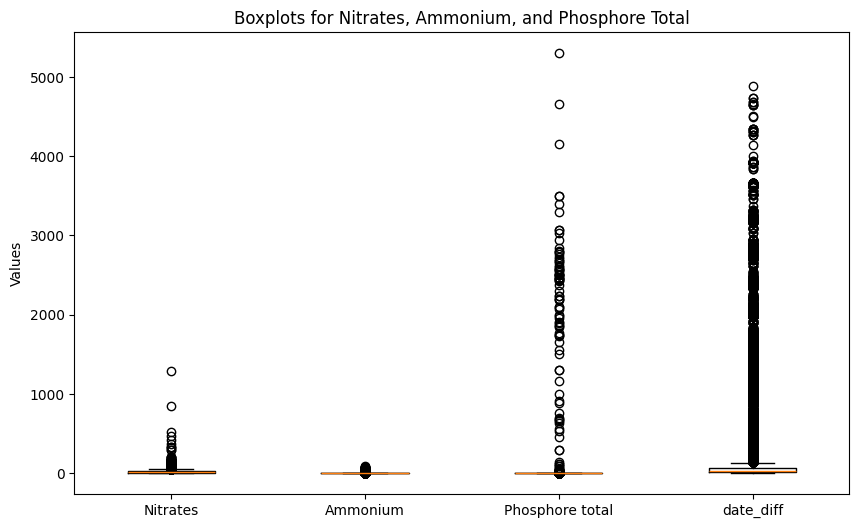

In [15]:
# Initialize lists to store values
values_nitrates = []
values_ammonium = []
values_phosphore_total = []

for index in all_index_list:
    param = df_param_all.loc[index, 'Value'][0]

    if index[3] == param_name[0]:  # 'Nitrates'
        values_nitrates.extend([float(value) for value in param])

    elif index[3] == param_name[1]:  # 'Ammonium'
        values_ammonium.extend([float(value) for value in param])

    elif index[3] == param_name[2]:  # 'Phosphore total'
        values_phosphore_total.extend([float(value) for value in param])

median_nitrates = np.median(values_nitrates)
median_ammonium = np.median(values_ammonium)
median_phosphore_total = np.median(values_phosphore_total)

IQR_nitrates = np.subtract(*np.percentile(values_nitrates, [75, 25]))
IQR_ammonium = np.subtract(*np.percentile(values_ammonium, [75, 25]))
IQR_phosphore_total = np.subtract(*np.percentile(values_phosphore_total, [75, 25]))

median_dict_param = {'Nitrates':median_nitrates, 'Ammonium':median_ammonium, 'Phosphore total':median_phosphore_total}
IQR_dict_param = {'Nitrates':IQR_nitrates, 'Ammonium':IQR_ammonium, 'Phosphore total':IQR_phosphore_total}

# Plotting the boxplots
plt.figure(figsize=(10, 6))
plt.boxplot([values_nitrates, values_ammonium, values_phosphore_total, date_diff_list], labels=param_name[:4])
plt.title("Boxplots for Nitrates, Ammonium, and Phosphore Total")
plt.ylabel("Values")
plt.show()


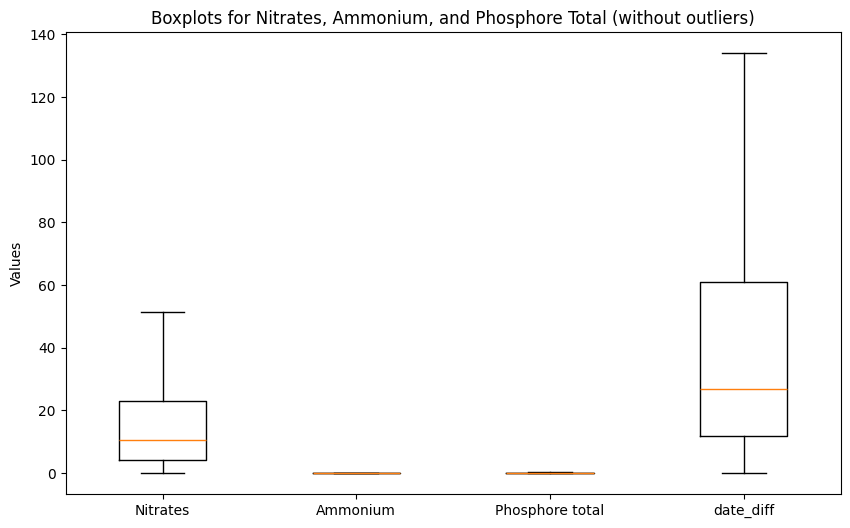

In [16]:
# Initialize lists to store values
values_nitrates = []
values_ammonium = []
values_phosphore_total = []

for index in all_index_list:
    param = df_param_all.loc[index, 'Value'][0]

    if index[3] == param_name[0]:  # 'Nitrates'
        values_nitrates.extend([float(value) for value in param])

    elif index[3] == param_name[1]:  # 'Ammonium'
        values_ammonium.extend([float(value) for value in param])

    elif index[3] == param_name[2]:  # 'Phosphore total'
        values_phosphore_total.extend([float(value) for value in param])

# Plotting the boxplots without outliers
plt.figure(figsize=(10, 6))
plt.boxplot([values_nitrates, values_ammonium, values_phosphore_total, date_diff_list], labels=param_name[:4], showfliers=False)
plt.title("Boxplots for Nitrates, Ammonium, and Phosphore Total (without outliers)")
plt.ylabel("Values")
plt.show()


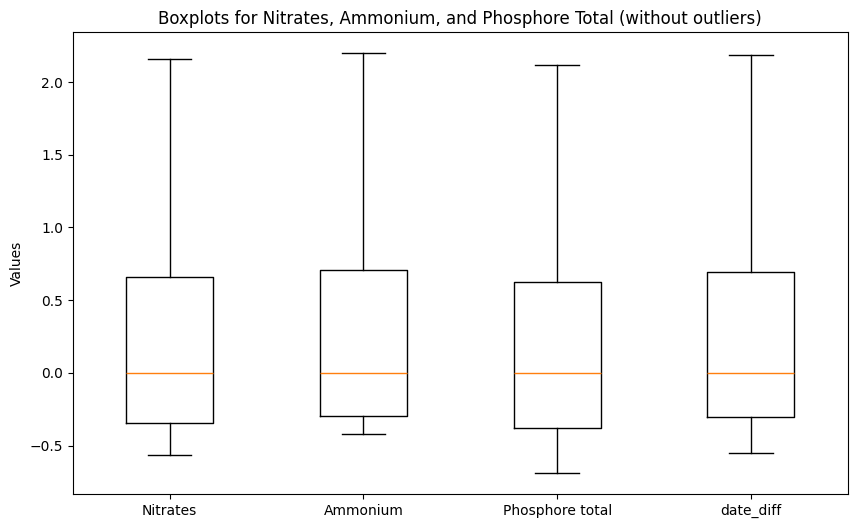

In [17]:
# Initialize lists to store values
values_nitrates_scaled = (np.array(values_nitrates, dtype=float) - median_dict_param['Nitrates']) / IQR_nitrates
values_ammonium_scaled = (np.array(values_ammonium, dtype=float) - median_dict_param['Ammonium']) / IQR_ammonium
values_phosphore_total_scaled = (np.array(values_phosphore_total, dtype=float) - median_dict_param['Phosphore total']) / IQR_phosphore_total
date_diff_list_scaled = (np.array(date_diff_list, dtype=float) - median_date_diff) / IQR_date_diff

# Plotting the boxplots without outliers
plt.figure(figsize=(10, 6))
plt.boxplot([values_nitrates_scaled , values_ammonium_scaled, values_phosphore_total_scaled, date_diff_list_scaled], labels=param_name[:4], showfliers=False)
plt.title("Boxplots for Nitrates, Ammonium, and Phosphore Total (without outliers)")
plt.ylabel("Values")
plt.show()

#### Analyse des param mesurés sur les staions

In [ ]:
nitrates_present_list = []
ammonium_present_list = []
phosphore_total_present_list = []

for station in dict_station_to_list_index_param:
    station_index = dict_station_to_list_index_param[station] 

    nitrates_present = 0
    ammonium_present = 0
    phosphore_total_present = 0
    for index in station_index:
        if index[3] == param_name[0] and index[2] == "Phase aqueuse de l'eau (filtrée, centrifugée...)":
            nitrates_present = 1
        elif index[3] == param_name[1] and index[2] == "Phase aqueuse de l'eau (filtrée, centrifugée...)":
            ammonium_present = 1
        elif index[3] == param_name[2] and index[2] == "Eau brute":
            phosphore_total_present = 1
    nitrates_present_list.append(nitrates_present)
    ammonium_present_list.append(ammonium_present)
    phosphore_total_present_list.append(phosphore_total_present)

#print taux param
    
print("Taux de présence de Nitrates:", sum(nitrates_present_list) / len(nitrates_present_list))
print("Taux de présence de Ammonium:", sum(ammonium_present_list) / len(ammonium_present_list))
print("Taux de présence de Phosphore Total:", sum(phosphore_total_present_list) / len(phosphore_total_present_list))

        

Taux de présence de Nitrates: 0.984594014395757
Taux de présence de Ammonium: 0.9703245359262533
Taux de présence de Phosphore Total: 0.9958328071726228


#### Pour le scaling on va juste ajuster les valeurs tels que le maximum des paramètres se retrouvent à 1

In [19]:
def compute_empty_input_stats(X_train_list):
    param_order = ['Nitrates', 'Ammonium', 'Phosphore total']

    empty_counts = {param: 0 for param in param_order}
    total_counts = {param: 0 for param in param_order}

    for station_data in X_train_list:
        for date_data in station_data:
            for i, param in enumerate(param_order):
                # Each parameter has 5 input values in your structure
                current_index = date_data[i * 5:(i + 1) * 5]

                # Check if all values for this parameter are None
                if all(v is None for v in current_index):
                    empty_counts[param] += 1

                total_counts[param] += 1

    # Calculating the percentage of empty inputs
    empty_number = {param: empty_counts[param] for param in param_order}

    return empty_number



In [20]:
min_empty = np.inf
for combination in tqdm(feature_combinations, desc="Processing combinations"):
    list_fraction_param = combination[1]
    X_train_list_test, Y_train, Y_train_scalers, station_list_for_dataset, index_list_for_dataset, date_diff_list= create_dataset(df_param_all, df_i2M2, list_fraction_param)
    print(" fractions: ", list_fraction_param)
    empty_number = compute_empty_input_stats(X_train_list_test)

    empty_number_sum = sum(empty_number.values())
    if empty_number_sum < min_empty:
        min_empty = empty_number_sum
        min_empty_fraction = list_fraction_param
        min_empty_number = empty_number

print("Sum empty parameters:", min_empty_number)
print("Min empty fraction:", min_empty_fraction)

    
    

Processing combinations:   0%|          | 0/20 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
i = 0
stop = False
for x in X_train_list:
    j=0
    for input in x:
        if np.any(np.isnan(input)):
            print(f"NaN dans la liste X {i}, input {j}: ",input)
            stop = True
            break
        if np.any(np.isinf(input)):
            print(f"Inf dans la liste {i}, input {j}: ",input)
            stop = True
            break
        j+=1
        
    i+=1
    if stop:
        break
    
k = 0
for y in Y_train:
    if np.any(np.isnan(y)):
        print(f"Nan dans la liste Y {i}:", np.any(np.isnan(y)))
        break
    if np.any(np.isinf(y)):
        print("Inf dans la liste Y {i}:", np.any(np.isinf(y)))
        break
    k+=1

In [ ]:
print("X_train example: ", X_train_list[0][0])

X_train example:  [None, None, None, None, None, None, None, None, None, None, 0.01098901098901099, 0.0, 2.830188679245283e-06, 0.0, 9.119496855345912e-07, 'CAUSSES AQUITAINS']
